# Address Matching with Apache Spark

## Iniciar Spark

In [1]:
from pyspark.sql.session import SparkSession

spark = spark = SparkSession.builder \
    .appName("Adress Matching") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "20g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

24/03/14 12:02:23 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.6.130.30 instead (on interface ens3)
24/03/14 12:02:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/14 12:02:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
conf = spark.sparkContext.getConf()
for (key, value) in conf.getAll():
  print(f"{key}: {value}")

spark.app.name: Adress Matching
spark.app.startTime: 1710417744691
spark.executor.id: driver
spark.driver.port: 46311
spark.driver.host: 10.6.130.30
spark.driver.extraJavaOptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false
spark.app.submi

## Leer fichero

El dataset continene exactamente 24 columnas las cuales, el ***, almacena información relevante el trabajo que realizan. En cambio, en este proyecto, se utilizarán las siguientes columnas pues contienen la información más relevante:
- **uuid_idt**: contiene un identificador alfanumérico único para cada dirección.
- **tvia**: contiene el tipo de vía, es decir, si es una calle, avenida, carretera, etc.
- **nvia**: contiene el nombre de la vía.
- **numer**: contiene el número de la vía.
- **codmun**: está compuesto por un código numérico que identifica a un municipio, es decir, el código postal.
- **nommun**: contiene el nombre del municipio.
- **direccion**: contiene la dirección completa."

In [3]:
# Leer el archivo CSV y cargarlo en un DataFrame
file =  "../data/raw_data/TFM_Direcciones.tab"
first_df = spark.read.option("delimiter", "\t").option("encoding", "windows-1252").csv(file, header=True, inferSchema=True)

# Seleccionar solo las columnas deseadas
selected_columns = [
  "uuid_idt",
  "tvia",
  "nvia",
  "numer",
  "codmun",
  "nommun",
  "direccion",
]
first_df = first_df.select(selected_columns)

# Mostrar el DataFrame
first_df.show()
first_df.schema
print(first_df.count())
size_df = first_df.count()

+--------------------+------------+--------------------+-----+------+------+--------------------+
|            uuid_idt|        tvia|                nvia|numer|codmun|nommun|           direccion|
+--------------------+------------+--------------------+-----+------+------+--------------------+
|027C0FF8-B17B-11E...|       CALLE|        FUENTE SANTA|    5| 35001|Agaete|CALLE FUENTE SANT...|
|028F2302-B17B-11E...|       CALLE|       CRUZ CHIQUITA|    2| 35001|Agaete|CALLE CRUZ CHIQUI...|
|02918516-B17B-11E...|URBANIZACION|RESIDENCIAL PALMERAL|    9| 35001|Agaete|URBANIZACION RESI...|
|03A306C0-7525-11E...|       CALLE|SEÑORITA MARIA MA...|    2| 35001|Agaete|CALLE SEÑORITA MA...|
|03A306C0-7525-11E...|       CALLE|SRTA M MANRIQUE LARA|    2| 35001|Agaete|CALLE SRTA M MANR...|
|03A306C0-7525-11E...|       CALLE| MARIA MANRIQUE LARA|    0| 35001|Agaete|CALLE MARIA MANRI...|
|03A306C0-7525-11E...|       CALLE| MARIA MANRIQUE LARA|    2| 35001|Agaete|CALLE MARIA MANRI...|
|03A306C0-7525-11E..

1784217


In [4]:
from pyspark.sql.functions import upper

file =  "../data/raw_data/data-09022024.csv"
second_df = spark.read.option('header', True).csv(file)

selected_columns = [
  "uuid_idt",
  "codmun",
  "nommun",
  "direccion"
]

second_df = second_df.select(selected_columns)
second_df = second_df.select(upper('uuid_idt').alias('uuid_idt'), 'codmun', upper('nommun').alias('nommun'), 'direccion')
second_df.show()
first_df.schema
print(second_df.count())
size_df += second_df.count()

+--------------------+------+--------------------+--------------------+
|            uuid_idt|codmun|              nommun|           direccion|
+--------------------+------+--------------------+--------------------+
|C0CF3B94-0AD1-11E...| 35016|LAS PALMAS DE GRA...|IGUAZU 42 0 LAS P...|
|73B57C1B-3251-11E...| 35016|LAS PALMAS DE GRA...|PARQUE CENTRAL BL...|
|C70E3EC6-3EDA-11E...| 35016|LAS PALMAS DE GRA...|CONCEJAL GARCIA F...|
|687BA81E-3251-11E...| 35006|              ARUCAS|PEDRO MORALES DEN...|
|74921989-3251-11E...| 35019|SAN BARTOLOMÉ DE ...|ISLA LOBOS 19 0 S...|
|6C0D19FF-3251-11E...| 35016|LAS PALMAS DE GRA...|CALLE LEON Y CAST...|
|6360FDCD-3251-11E...| 35016|LAS PALMAS DE GRA...|VIGEN PILAR 45 4 ...|
|758B3855-3251-11E...| 35016|LAS PALMAS DE GRA...|CALLE PALMERA CAN...|
|5D36841A-7A6B-11E...| 35016|LAS PALMAS DE GRA...|RUPERTO CHAPI 0 L...|
|6C00DBF4-3251-11E...| 35021|       SANTA BRÍGIDA|MANUEL HERNANDEZ ...|
|733A49C5-3251-11E...| 35027|               TEROR| HERRERIA 36 0

630297


In [5]:
print(size_df)

2414514


In [6]:
from pyspark.sql.functions import count

def uuid_frecuency(dataframe):
    values_under_10 = dataframe.groupBy(dataframe.uuid_idt).count() \
        .filter('count < 9') \
        .groupBy('count') \
        .agg(count('*') \
        .alias('Frecuencia')) \
        .orderBy('count')
    values_under_10 = values_under_10.withColumnRenamed('count', 'Número de direcciones asociadas')

    values_over_10 = dataframe.groupBy(dataframe.uuid_idt).count() \
        .filter('count > 9')
    values_over_10 = spark.createDataFrame(
        [['10 o más', values_over_10.count()]],
        ['Número de direcciones asociadas', 'Frecuencia']
        )

    values = values_under_10.union(values_over_10)
    values.show()

uuid_frecuency(first_df)
uuid_frecuency(second_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    267275|
|                              2|    115343|
|                              3|     60757|
|                              4|     35631|
|                              5|     22207|
|                              6|     14810|
|                              7|     10142|
|                              8|      7411|
|                       10 o más|     25539|
+-------------------------------+----------+



+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    250632|
|                              2|     51645|
|                              3|     19692|
|                              4|      9055|
|                              5|      4702|
|                              6|      2876|
|                              7|      1772|
|                              8|      1161|
|                       10 o más|      4083|
+-------------------------------+----------+



## Unión de los dataframes

In [7]:
# Seleccionar los UUID únicos del primer DataFrame
unique_uuid_first_df = first_df.select("uuid_idt").distinct()

# Seleccionar los UUID únicos del segundo DataFrame
unique_uuid_second_df = second_df.select("uuid_idt").distinct()

# Encontrar los UUID comunes
uuid_comunes = unique_uuid_first_df.join(unique_uuid_second_df, "uuid_idt", "inner")
# Da el mismo resultado: uuid_primero.intersect(uuid_segundo)

# Juntar los UUID comunes con el primer DataFrame
adresses_df = first_df.unionByName(second_df.join(uuid_comunes, "uuid_idt", "inner"), allowMissingColumns=True)

# Mostrar el resultado
adresses_df.show()
print("Tamaño del dataframe ampliado: ", adresses_df.count())

# Si se quiere comprobar que la operación es correcta
print("Número de uuid_idt nuevos del segundo dataframe: ", unique_uuid_second_df.subtract(uuid_comunes).count())

+--------------------+------------+--------------------+-----+------+------+--------------------+
|            uuid_idt|        tvia|                nvia|numer|codmun|nommun|           direccion|
+--------------------+------------+--------------------+-----+------+------+--------------------+
|027C0FF8-B17B-11E...|       CALLE|        FUENTE SANTA|    5| 35001|Agaete|CALLE FUENTE SANT...|
|028F2302-B17B-11E...|       CALLE|       CRUZ CHIQUITA|    2| 35001|Agaete|CALLE CRUZ CHIQUI...|
|02918516-B17B-11E...|URBANIZACION|RESIDENCIAL PALMERAL|    9| 35001|Agaete|URBANIZACION RESI...|
|03A306C0-7525-11E...|       CALLE|SEÑORITA MARIA MA...|    2| 35001|Agaete|CALLE SEÑORITA MA...|
|03A306C0-7525-11E...|       CALLE|SRTA M MANRIQUE LARA|    2| 35001|Agaete|CALLE SRTA M MANR...|
|03A306C0-7525-11E...|       CALLE| MARIA MANRIQUE LARA|    0| 35001|Agaete|CALLE MARIA MANRI...|
|03A306C0-7525-11E...|       CALLE| MARIA MANRIQUE LARA|    2| 35001|Agaete|CALLE MARIA MANRI...|
|03A306C0-7525-11E..

Tamaño del dataframe ampliado:  2234214


Número de uuid_idt nuevos del segundo dataframe:  148073


In [8]:
uuid_frecuency(adresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    211768|
|                              2|    119917|
|                              3|     70050|
|                              4|     44000|
|                              5|     28925|
|                              6|     19650|
|                              7|     14050|
|                              8|     10331|
|                       10 o más|     38060|
+-------------------------------+----------+



## Partición del dataset

In [9]:
adresses_df = adresses_df.repartition(32)

## Limpieza del dataset

Tras visualizar el dataset, se observa que hay columnas que tienen valores desconocidos, representados con '_U', y camos vacíos.

In [10]:
print(f"Initial dataset size: {adresses_df.count()}")

Initial dataset size: 2234214


### Valores nulos

In [11]:
from pyspark.sql.functions import isnan, when, count, col

adresses_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in adresses_df.columns]).show()

+--------+------+------+------+------+------+---------+
|uuid_idt|  tvia|  nvia| numer|codmun|nommun|direccion|
+--------+------+------+------+------+------+---------+
|       0|580357|460216|449997|     0|     0|        0|
+--------+------+------+------+------+------+---------+



In [12]:
adresses_df = adresses_df.na.fill('_U')

adresses_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in adresses_df.columns]).show()

+--------+----+----+------+------+------+---------+
|uuid_idt|tvia|nvia| numer|codmun|nommun|direccion|
+--------+----+----+------+------+------+---------+
|       0|   0|   0|449997|     0|     0|        0|
+--------+----+----+------+------+------+---------+



### Extracción del prefijo para eleminar valores '_U'

Tras analizar el dataset, se observa que para una dirección, el tipo de vía (tvia) puede aparecer vacío, en cambio, en la columna 'direccion' aparece este valor. Por lo que se procederá a extraer el prefijo de la columna 'direccion' para rellenar los valores vacíos de la columna 'tvia' evitando así la perdida de información.

In [13]:
print(f"Unknown tvia before prefix extraction: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia before prefix extraction: 580357


In [14]:
tvia_types = adresses_df.select("tvia").distinct().collect()
tvia_types = {t.tvia for t in tvia_types if t.tvia != "_U" and not t.tvia.isnumeric()}
print(tvia_types)

{'AUTOVIA', 'SB', 'EXTRARRADIO', 'POLIG', 'VIA', 'PUENTE', 'COOPERATIVA', 'LADERA', 'PLAZA', 'TVERA', 'DISEMINADO', 'PORTALES', 'PLAZUELA', 'BULEVAR', 'CAS', 'RUA', 'SENDA', 'CC', 'LLANO', 'CSRIO', 'PASEO ALTO', 'PASILLO', 'CAMNO', 'PAGO', 'TORRENTE', 'PARQ', 'PZTA', 'AGRUP', 'CALLEJUELA', 'VEREDA', 'PASEO BAJO', 'PARQUE', 'TRASERA', 'RAMBL', 'COSTANILLA', 'RINCONADA', 'MANZANA', 'BARRA', 'MUNICIPIO', 'BARRIO', 'JARDIN', 'ESCALINATA', 'CUESTA', 'ACERA', 'BAJADA', 'LU', 'AVENI', 'BRNCO', 'CALE', 'PASO', 'VIVIENDAS', 'ACCESO', 'PASAJE', 'PRJE', 'SENDERO', 'MONTAÑA', 'RONDA', 'APARTAMENTOS', 'OTROS', 'CMINO', 'PLAZOLETA', 'CASERIO', 'TORRE', 'PLAYA', 'ENTRADA', 'CALLEJA', 'TRAVESIA', 'AVENIDA', 'FINCA', 'CHALET', 'PRIVADA', 'EDIFICIO', 'CONJUNTO', 'ATAJO', 'PATIO', 'EDIF', 'BARRIADA', 'LOMO', 'PARTICULAR', 'SECTOR', 'CORRAL', 'ROTONDA', 'BLOQUES', 'CRTA', 'CARRETERA', 'ESCALERA', 'CALZADA', 'RESIDENCIAL', 'UB', 'C', 'URBANIZACION', 'GLORIETA', 'RAMAL', 'VALLE', 'CAMIN', 'CRA', 'DC', 'PIST

In [15]:
from pyspark.sql.functions import regexp_extract, when

condition = (adresses_df.tvia == '_U') & (regexp_extract('direccion', r'^(\\S+)', 1).isin(tvia_types))
adresses_df = adresses_df.withColumn("tvia", when(condition, regexp_extract('direccion', r'^(\\S+)', 1)).otherwise(adresses_df.tvia))

In [16]:
print(f"Unknown tvia before prefix extraction: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia before prefix extraction: 580357


Se puede observar que los tipos de vías que siguen siendo desconocidos es debido a que desde la columna de dirección no se ha podido extraer un prefijo que aparezca en la lista de los tipos de vías que tenemos en el dataset.

### Limpieza de entradas con valor '_U'

Tras realizar la limpieza del dataset y extraer el tipo de via de la columna 'direccion', se procederá a eliminar las entradas restantes que contengan valores '_U' en las columnas 'tvia' pues no aportan información relevante.

In [17]:
print(f"Unknown tvia before duplicated null cleaning: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia before duplicated null cleaning: 580357


In [18]:
adresses_df = adresses_df.filter(adresses_df.tvia != '_U')

In [19]:
print(f"Unknown tvia after duplicated null cleaning: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia after duplicated null cleaning: 0


In [20]:
print(f"Tamaño final del dataframe: {adresses_df.count()}")

Tamaño final del dataframe: 1653857


## Aumento de datos

### Frecuencia de uuid_idt antes

In [21]:
uuid_frecuency(adresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    278002|
|                              2|    109890|
|                              3|     57031|
|                              4|     32912|
|                              5|     20151|
|                              6|     13280|
|                              7|      9074|
|                              8|      6577|
|                       10 o más|     22563|
+-------------------------------+----------+



### Aumento de datos

- Cambiar el orden de las palabras
- Añadir errores ortográficos
- Añadir sinónimos

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import random

# Define la función UDF
def switch_letters(direcction):
    """Intercambia letras adyacentes en una palabra"""
    words = direcction.split()
    word_candidates = [word for word in words if word.isalpha() and len(word) >= 2]
    if not word_candidates:
        return direcction
    word = random.choice(word_candidates)
    pos = random.randint(0, len(word) - 2)
    return " ".join(
        w if w != word else w[:pos] + w[pos + 1] + w[pos] + w[pos + 2:]
        for w in words
    )

def update_direction_via(tvia, direction):
    """Actualiza el tipo de vía de la dirección"""
    old_tvia = direction.split(" ")[0]
    if tvia.upper() in tvia_types:   
        direction = direction.replace(old_tvia, tvia)
    return direction

def select_via_type(tvia):
    """Selecciona tipos de vía alternativos sin duplicados"""
    return random.choice([t for t in tvia_types if t.title() != tvia and t != tvia.lower()])


unique_filtered_uuids = adresses_df.groupBy("uuid_idt").count().filter("count < 10").select("uuid_idt").sample(0.5)

to_extend = adresses_df.join(unique_filtered_uuids, "uuid_idt")

# Registra la función UDF con Spark
spark.udf.register("switch_letters", switch_letters, StringType())
spark.udf.register("select_via_type", select_via_type, StringType())
spark.udf.register("update_direction_via", update_direction_via, StringType())

# Aplica la función UDF a la columna "direccion" usando withColumn
extended_ds = (to_extend
    .withColumn("tvia", udf(select_via_type, StringType())("tvia"))
    .withColumn("direccion", udf(update_direction_via, StringType())("tvia", "direccion"))
    .withColumn("direccion", udf(switch_letters, StringType())("direccion"))
)

extended_ds.show(truncate=False)
print(extended_ds.count(), adresses_df.count())
adresses_df = adresses_df.union(extended_ds)
print(adresses_df.count())

+------------------------------------+------------+---------------------------------+-----+------+--------------------------+-------------------------------------------------------+
|uuid_idt                            |tvia        |nvia                             |numer|codmun|nommun                    |direccion                                              |
+------------------------------------+------------+---------------------------------+-----+------+--------------------------+-------------------------------------------------------+
|008B0887-AC4D-4713-B9E5-07E6CED0604F|CC          |POLO 106A                        |20   |38026 |La Orotava                |CC POLO 106A 20 LA OROTAVA                             |
|008B0887-AC4D-4713-B9E5-07E6CED0604F|C           |POLO 106 A                       |20   |38026 |La Orotava                |C POOL 106 A 20 LA OROTAVA                             |
|00C1ED5D-A7A0-4E1C-8F5E-2B011F4D0C72|SECTOR      |PEDRO Y GUY VANDAELE ARENA DORADA|10   

569999 1653857


2223856


### Frecuencia de uuid_idt después

In [23]:
uuid_frecuency(adresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    138838|
|                              2|    194489|
|                              3|     28695|
|                              4|     70892|
|                              5|      9967|
|                              6|     34870|
|                              7|      4607|
|                              8|     19950|
|                       10 o más|     49616|
+-------------------------------+----------+



## División de dataset

In [24]:
# Obtener los uuids únicos y convertirlos a una lista de Python
unique_uuids = [row[0] for row in adresses_df.select("uuid_idt").distinct().collect()]

In [25]:
# Crear DataFrame del 80%
train_df = adresses_df.sampleBy("uuid_idt", fractions={uuid: 0.8 for uuid in unique_uuids}, seed=42)

# Crear DataFrame del 20% restando el DataFrame del 80% al original
test_df = adresses_df.subtract(train_df)

In [26]:
print(adresses_df.count())
print(train_df.count())
print(test_df.count())

2223856


24/03/14 12:08:27 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


1777673


24/03/14 12:09:01 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:09:36 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:09:49 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


900584


In [27]:
print(adresses_df.select("uuid_idt").distinct().count())
print(train_df.select("uuid_idt").distinct().count())
print(test_df.select("uuid_idt").distinct().count())

554325


24/03/14 12:10:15 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:10:30 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


518601


24/03/14 12:10:47 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:11:27 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:11:35 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


378427


In [28]:
uuid_frecuency(train_df)
uuid_frecuency(test_df)

24/03/14 12:11:48 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:12:03 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:12:15 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:12:28 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:12:35 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:12:37 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:12:40 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:12:42 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:12:44 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    178923|
|                              2|    146639|
|                              3|     48969|
|                              4|     43311|
|                              5|     21872|
|                              6|     18615|
|                              7|     12050|
|                              8|     10377|
|                       10 o más|     29927|
+-------------------------------+----------+



24/03/14 12:13:02 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:13:39 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:13:49 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:13:55 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:14:13 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:14:49 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:14:58 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:15:03 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:15:10 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:15:12 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:15:14 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/03/14 12:15:16 WARN DAGScheduler: Broadc

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    187540|
|                              2|     81405|
|                              3|     39644|
|                              4|     23482|
|                              5|     14960|
|                              6|      9786|
|                              7|      7000|
|                              8|      4936|
|                       10 o más|      6152|
+-------------------------------+----------+



In [42]:
# Escribir el resultado en un archivo parquet
try:
  train_df.write.format('parquet').save("../data/proccesed_data/train_dataframe.parquet")
except:
  print('No se pudo guardar el dataset de entrenamiento.')

24/03/13 22:59:38 WARN DAGScheduler: Broadcasting large task binary with size 28.3 MiB


In [ ]:
# Escribir el resultado en un archivo parquet
try:
  test_df.write.format('parquet').save("../data/proccesed_data/test_dataframe.parquet")
except:
  print('No se ha podido guardar el dataset de testeo.')

## Representación con embeddings

#### Lectura del dataframe de entrenamiento

In [ ]:
try:
  train_df = spark.read.format('parquet').load('train_dataframe.parquet')
except:
  print('No se ha podido leer el dataset de entrenamiento.')

### Representación mediante _Word2Vec_

In [30]:
from pyspark.ml.feature import Word2Vec, Tokenizer

# Tokenizar el texto
tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
data_tokenized = tokenizer.transform(train_df)

# Entrenar el modelo Word2Vec
word2Vec = Word2Vec(vectorSize=300, minCount=0, inputCol="words", outputCol="embedding")
model_word2vec = word2Vec.fit(data_tokenized)

# Transformar los datos
result_word2vec = model_word2vec.transform(data_tokenized)
# ~9min

24/03/14 12:24:08 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/03/14 12:24:38 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


In [31]:
result_word2vec.show(truncate=False)

24/03/14 12:32:13 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


+------------------------------------+--------+----------------------------+-----+------+----------+-------------------------------------------+----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Escritura del modelo y del dataset con el embedding

In [ ]:
try:
  model_word2vec.write().overwrite().save("../models/word2vec_model")
except:
  print('No se ha podido guardar el modelo word2vec.')

In [ ]:
try:
  result_word2vec.write.format('parquet').save("../data/proccesed_data/word2vec_result.parquet")
except:
  print('No se ha podido guardar el dataset con embedding word2vec.')

### Representación con GPT

In [32]:
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf
from openai import OpenAI

def get_embedding(text, model="text-embedding-3-small"):
    client = OpenAI(api_key="***REMOVED***")
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

# Definir la función UDF y especificar el tipo de dato de retorno como ArrayType(FloatType())
embedding_udf = udf(lambda text: get_embedding(text), ArrayType(FloatType()))

# Aplicar la función UDF al DataFrame y crear una nueva columna llamada embeddings"
result_gpt3 = train_df.withColumn("embeddings", embedding_udf("direccion"))

In [33]:
result_gpt3.show(truncate=False)

24/03/14 12:32:32 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


+------------------------------------+--------+----------------------------+-----+------+----------+-------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
try:
  result_gpt3.write.format('parquet').save("gpt3_result.parquet")
except:
  print('No se ha podido guardar el dataset con embedding de gpt3.')

No se ha podido guardar el dataset con embedding de gpt3.


### Representación con BERT

In [34]:
from sentence_transformers import SentenceTransformer
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf
model = SentenceTransformer("all-MiniLM-L6-v2")

def minilm_embedding(direccion):
    """ Calcula el embedding de la direccion dada y lo convierte a una lista para evitar la serelización de Spark """
    # Sentences are encoded by calling model.encode()
    embedding = model.encode(direccion)
    return embedding.tolist()  # Convertir el embedding a una lista de Python para evitar la serelización

@udf(returnType=ArrayType(FloatType()))
def minilm_embedding_udf(direccion):
    return minilm_embedding(direccion)

result_minilm = train_df.withColumn("embeddings", minilm_embedding_udf("direccion"))
result_minilm.show(truncate=False)

/home/usuario/Adress-matching/adress_matching_spark/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/usuario/Adress-matching/adress_matching_spark/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
24/03/14 12:33:18 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


+------------------------------------+--------+----------------------------+-----+------+----------+-------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
try:
  result_minilm.write.format('parquet').save("minilm_result.parquet")
except:
  print('No se ha podido guardar el dataset con embedding de minilm.')

### Representación gráfica

In [43]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
tokenized_sentences = tokenizer.transform(adresses_df).select("words").collect()
tokenized_sentences = [sentence.words for sentence in tokenized_sentences]
print(tokenized_sentences[:10])

[['calle', 'sotavento', '118', 'antigua'], ['calle', 'fermina', '55', 'arrecife'], ['calle', 'b', 'villa', 'pirula', '26', 'la', 'oliva'], ['calle', 'bilbao', '55', 'arrecife'], ['calle', 'guanarteme', 'cruce', 'arinaga', '133', 'agüimes'], ['calle', 'dr', 'barnard', '3', 'ingenio'], ['calle', 'palmeral', '1', 'haria'], ['calle', 'verol', 'caleta', 'fuste', '25', 'antigua'], ['calle', 'diama', 'argana', 'alta', '41', 'arrecife'], ['calle', 'camino', 'volcan', 'macher', '7', 'arrecife']]


In [44]:
word_counter = dict()
for sentence in tokenized_sentences:
    for word in sentence:
        if word not in word_counter:
            word_counter[word] = 1
        else:
            word_counter[word] += 1

word_counter = spark.createDataFrame(
    word_counter.items(),
    ["word", "count"]
).orderBy("count", ascending = False)

# Creo la columa frecuencia
word_counter = word_counter.withColumn(
    "frequency",
    word_counter["count"] / word_counter.count()
)
word_counter.show()

+---------+-------+------------------+
|     word|  count|         frequency|
+---------+-------+------------------+
|    calle|1163413| 9.293772267578406|
|       de| 986749| 7.882515058075442|
|      san| 472357|3.7733619849499127|
|       la| 398967|3.1870955888226744|
|    santa| 284956|  2.27633365819367|
|     gran| 239066|1.9097474077742806|
|  canaria| 227919|1.8207010592577209|
|     cruz| 223415|1.7847214455752425|
|   laguna| 212344|1.6962822130977298|
|cristobal| 210656|1.6827978463357351|
|   palmas| 197716|1.5794283523190236|
|      las| 195927|1.5651371602946111|
| tenerife| 158943|1.2696953236088255|
|        0| 145827|1.1649198766595836|
|  avenida| 124761|0.9966368966784362|
|   camino| 109241|0.8726574108098608|
|        1| 107785|0.8610263456407471|
| tirajana| 105365|0.8416944928184563|
|      los| 102426|0.8182166765189883|
|carretera| 101723|0.8126008531578023|
+---------+-------+------------------+
only showing top 20 rows



<Axes: xlabel='word'>

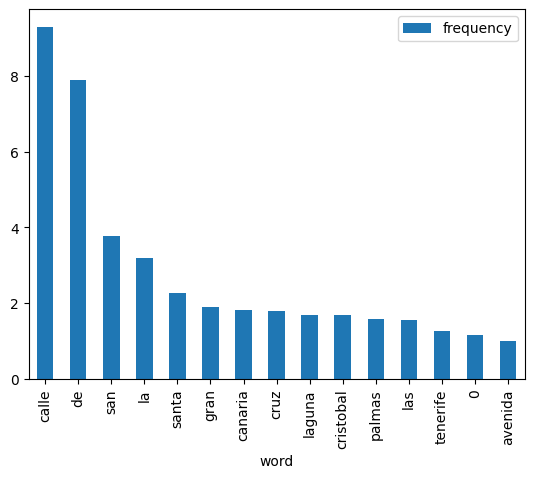

In [45]:
import matplotlib.pyplot as plt
# Imprimir las 20 palabras más frecuentes
word_counter.toPandas().head(15).plot.bar(x = "word", y = "frequency")